<a href="https://colab.research.google.com/github/robincaron13/macroPerso/blob/main/SoSDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# School of Statistics 2022 -- Deep Learning 
###  by Veronica Sanz (Universitat de Valencia/ IFIC and University of Sussex)

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML
%matplotlib inline
import time
np.random.seed(42) 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
drive_dir = '/content/gdrive/My Drive/SoSDL'
os.chdir('/content/gdrive/My Drive/SoSDL')

##  As you already gained familiarity with the WW dataset, let's use it to illustrate NNs and clustering

In [ ]:
# data was created from ATLAS Open Data see doc
# http://opendata.atlas.cern/release/2020/documentation/datasets/intro.html
filename=os.path.join(drive_dir,"dataWW_d1_600k.csv.gz")
#load data

df = pd.read_csv(filename) 

#From David: shuffle the events, and apply min sel cuts
df = df.sample(frac=1).reset_index(drop=True)
df=df[(df.lep_n==2) & (df.mcWeight > 0)]  
print ("File loaded with ",df.shape[0], " events ")


File loaded with  577357  events 


## Let's start with DataViz! 
###EDA is a very important aspect of Data Science but in PP we are used to already know a lot about the data: MC labels, no outliers, canonical ways to represent the data... This is not what happens in 'real life'

In [ ]:
df.isna().sum()

eventNumber      0
label            0
met_et           0
met_phi          0
lep_n            0
lep_pt_0         0
lep_pt_1         0
lep_eta_0        0
lep_eta_1        0
lep_phi_0        0
lep_phi_1        0
lep_E_0          0
lep_E_1          0
lep_charge_0     0
lep_charge_1     0
lep_type_0       0
lep_type_1       0
jet_n            0
jet_pt_0         0
jet_pt_1         0
jet_eta_0        0
jet_eta_1        0
jet_phi_0        0
jet_phi_1        0
jet_E_0          0
jet_E_1          0
mcWeight         0
runNumber        0
channelNumber    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

We know this is not our case, but often we find categorical features which need to be dealt with. Checking there are no categorical features:

In [ ]:
catdf = [item for item in df.columns if 'cat' in item]
catdf

[]

In [ ]:
df.columns.tolist()

We prepare databases with a smaller amount of features, leptons+MET (as in your analysis with David) and leptons+ MET+ jets

In [ ]:
feat1=['met_et','met_phi','lep_pt_0','lep_pt_1','lep_phi_0','lep_phi_1']
featr=['met_et','met_phi','lep_pt_0','lep_pt_1','lep_phi_0','lep_phi_1','label']
feat2=['met_et','met_phi','lep_pt_0','lep_pt_1','lep_phi_0','lep_phi_1','jet_n','jet_pt_0','jet_pt_1','jet_phi_0','jet_phi_1']
target = df["label"]
df1=df[feat1]
df2=df[feat2]

## Let's also keep a balanced subset for plotting (using undersampling) and a smaller dataset for costly clustering methods later on

In [ ]:
n_minority_class = df.label.value_counts().min()
df_balanced = df.groupby('label').sample(n=n_minority_class, replace=False)
assert df_balanced.shape[0] == 2 * n_minority_class
df_balanced.label.value_counts()
dfreduced=df_balanced[featr].sample(n=10000)

## We can do a pairwise plot of the main 6 features witht the smaller and balanced dataset

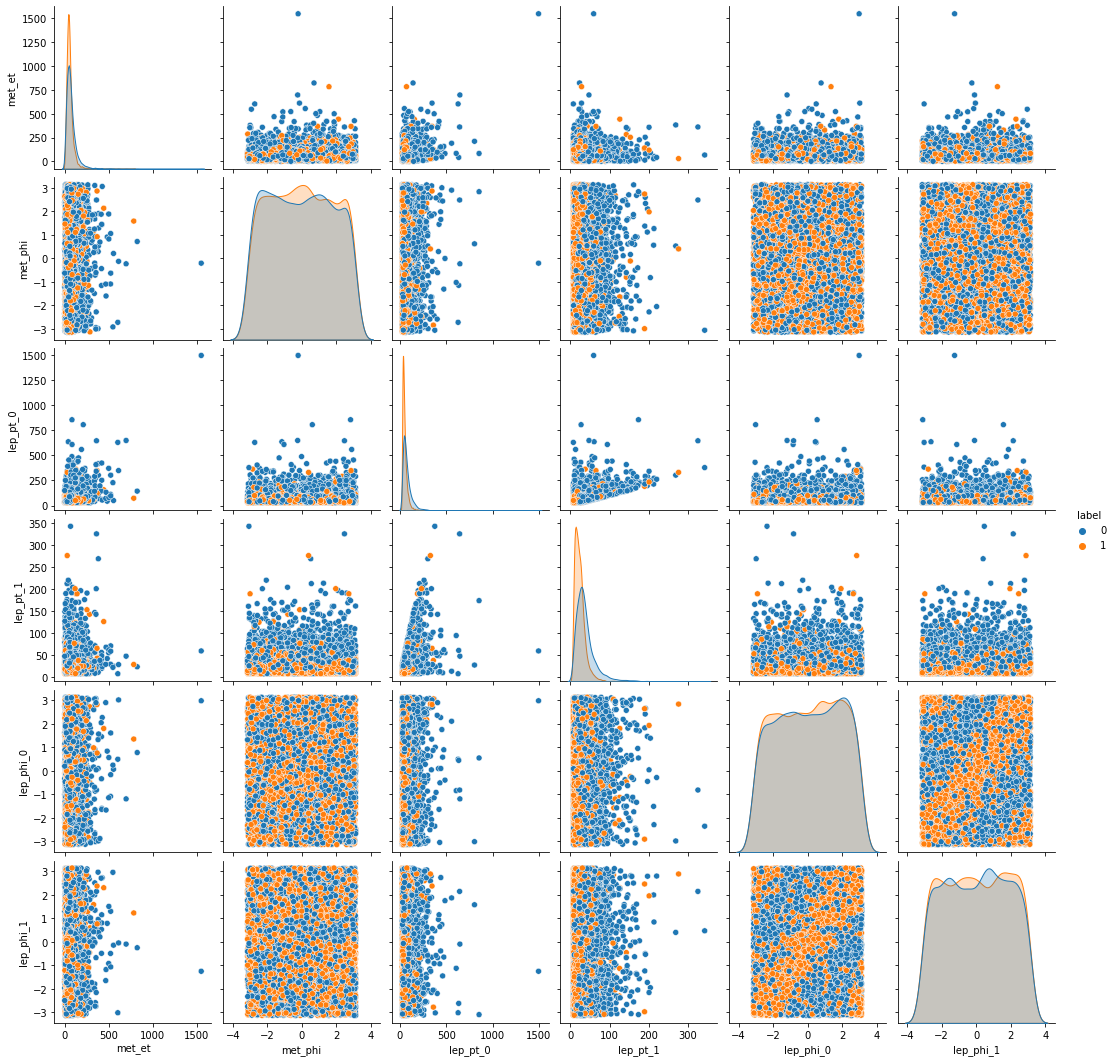

In [ ]:
sns.pairplot(dfreduced, hue='label')
plt.savefig(drive_dir+'/pairwiseSNS')

## Sometimes the density of points is better represented in another way. Here we use KDE

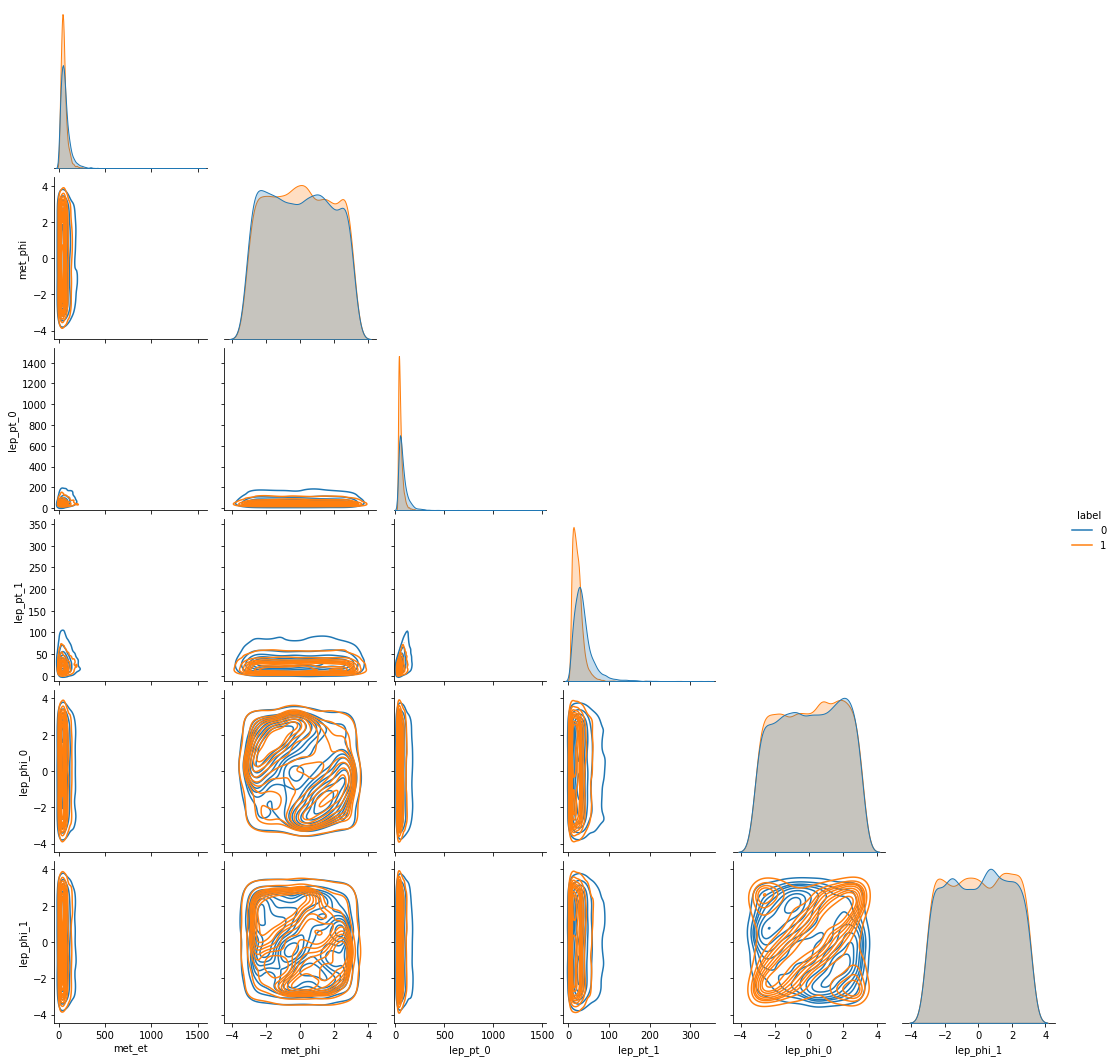

In [ ]:
sns.pairplot(dfreduced, hue='label', kind='kde', corner=True)
plt.savefig(drive_dir+'/pairwiseKDE')

## Zooming into some interesting correlations. We'll see how these will become clearer when we do clustering later in the notebook

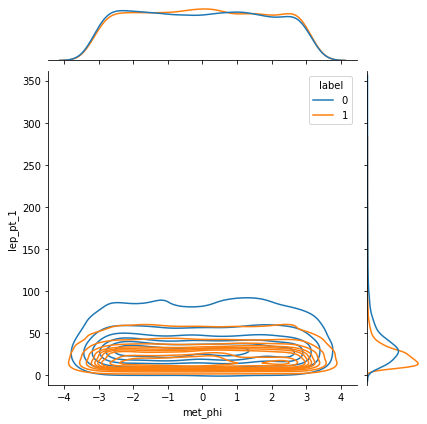

In [ ]:
sns.jointplot(data=dfreduced, x='met_phi', y='lep_pt_1', hue='label', kind='kde')

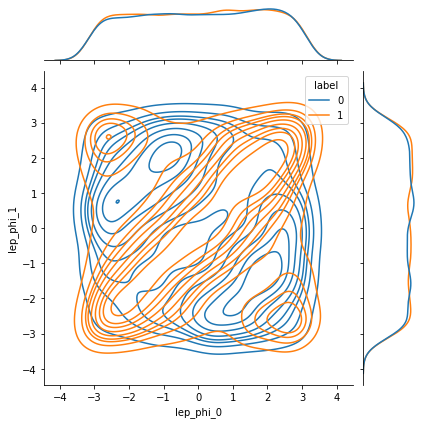

In [ ]:
sns.jointplot(data=dfreduced, x='lep_phi_0', y='lep_phi_1', hue='label', kind='kde')

##You already did the feature analysis with the lepton and MET. Here we can also see what's going on with the jets. They are correlated between each other (radiation patter) and also with the rest of the event (indicate boost of the overall event)

Background feature correlation matrix


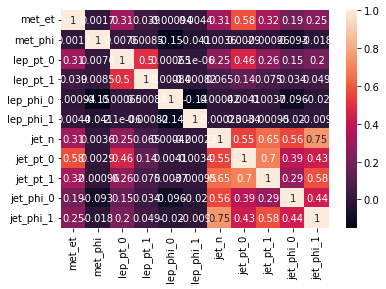

Signal feature correlation matrix


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


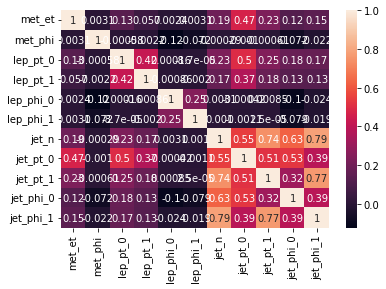

In [ ]:
print ("Background feature correlation matrix")
corrMatrix = df2[target==0].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

print ("Signal feature correlation matrix")
corrMatrix = df2[target==1].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()


# Neural Networks with TF
### in the lecture slides I linked another notebook using FastAI, a wrapper of pythorch, which you could explore once you finish this 

In [ ]:
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

### Start by separating the data between the training data and the unseen test data

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df_balanced[feat1], df_balanced['label'], test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(df1, target, test_size=0.2)
print(len(X_train), 'train examples')
print(len(X_test), 'test examples')


461885 train examples
115472 test examples


We keep this small dataset for later use

In [ ]:
X_red=dfreduced[feat1]
y_red=dfreduced['label']
print(X_red.shape,y_red.shape)

(10000, 6) (10000,)


We have to standarise the features

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # From David's code: applied the transformation calculated the line above
X_red  = scaler.fit_transform(X_red)

In [ ]:
X_train.std()

1.0

Define the NN architecture

In [ ]:
fcmodel = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(6,)), # input layer
  tf.keras.layers.Dense(128, activation='relu'), # 1st hiddden layer
  tf.keras.layers.Dense(50, activation='relu'), # 2nd hidden layer
  tf.keras.layers.Dense(1,activation="sigmoid") # output layer
])


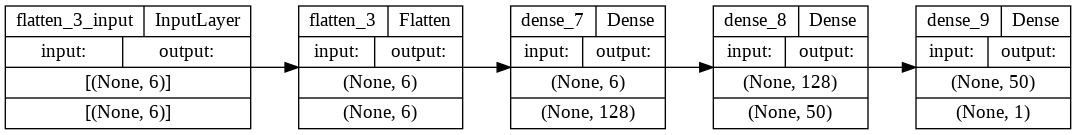

In [ ]:
tf.keras.utils.plot_model(fcmodel, show_shapes=True, rankdir="LR")

Define how the  architecture will be used, including optimizers and loss function

In [ ]:
opt = tf.keras.optimizers.Adam()
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
opt2= tf.keras.optimizers.SGD(learning_rate=0.01)
fcmodel.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])


Here we define a model checkpoint to save the best performing model and also the patience function, to stop running once the NN is not learning anymore

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath = drive_dir+'/my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callbacks = [checkpoint,patience]

In [ ]:
history = fcmodel.fit(X_train, y_train,
                      epochs=20,
                      verbose=3,
                      validation_split=0.2,
                      callbacks=callbacks
                      )

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.36440, saving model to /content/gdrive/My Drive/SoSDL/my_best_model.hdf5
Epoch 2/20

Epoch 2: val_loss did not improve from 0.36440
Epoch 3/20

Epoch 3: val_loss improved from 0.36440 to 0.35884, saving model to /content/gdrive/My Drive/SoSDL/my_best_model.hdf5
Epoch 4/20

Epoch 4: val_loss improved from 0.35884 to 0.35658, saving model to /content/gdrive/My Drive/SoSDL/my_best_model.hdf5
Epoch 5/20

Epoch 5: val_loss improved from 0.35658 to 0.35606, saving model to /content/gdrive/My Drive/SoSDL/my_best_model.hdf5
Epoch 6/20

Epoch 6: val_loss improved from 0.35606 to 0.35404, saving model to /content/gdrive/My Drive/SoSDL/my_best_model.hdf5
Epoch 7/20

Epoch 7: val_loss did not improve from 0.35404
Epoch 8/20

Epoch 8: val_loss improved from 0.35404 to 0.35262, saving model to /content/gdrive/My Drive/SoSDL/my_best_model.hdf5
Epoch 9/20

Epoch 9: val_loss did not improve from 0.35262
Epoch 10/20

Epoch 10: val_loss improved from 0

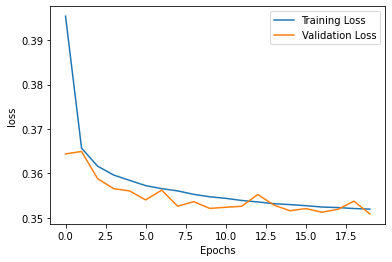

In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.savefig('model_training_history')
plt.show()

Above we have the default history plot, but we also want to look at accuracy so we define our own plotting function

In [ ]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss','val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy','val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_accuracy) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

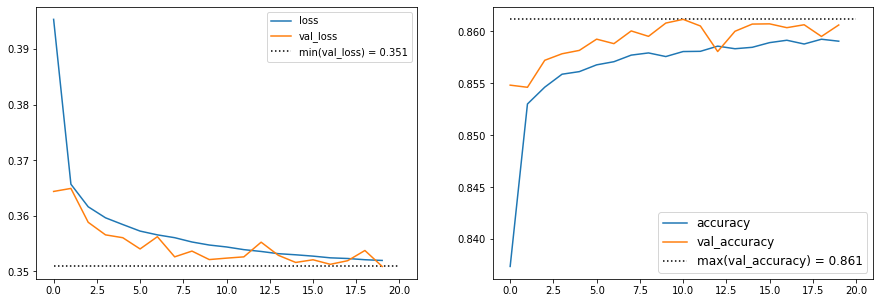

In [ ]:
histplot(history)

How well did this model do? With 6 features it got AUC of 88%

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.models import  load_model
#Load and evaluate the best model version
model = load_model(filepath)
y_pred_test = model.predict(X_test).ravel()
auc = roc_auc_score(y_true=y_test, y_score=y_pred_test)
print("AUC",auc)


AUC 0.8761277814488728


## Does it help to add a bit more information on the event? we go from 6 to 11 features (jet info)

In [ ]:
#X2_train, X2_test, y2_train, y2_test = train_test_split(df_balanced[feat2], df_balanced['label'], test_size=0.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(df2, target, test_size=0.2)
X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

In [ ]:
fcmodel2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(11,)), # input layer
  tf.keras.layers.Dense(128, activation='relu'), # 1st hiddden layer
  tf.keras.layers.Dense(128, activation='relu'), # 2nd hidden layer
  tf.keras.layers.Dense(1,activation="sigmoid") # output layer
])
fcmodel2.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
filepath2 = drive_dir+'/my_best_model2.hdf5'
checkpoint2 = ModelCheckpoint(filepath=filepath2, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks2=[checkpoint2,patience]

In [ ]:
history2 = fcmodel2.fit(X2_train, y2_train,
                      epochs=25,
                      verbose=2,
                      validation_split=0.2,
                      callbacks=callbacks2
                      )

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.35178, saving model to /content/gdrive/My Drive/SoSDL/my_best_model2.hdf5
11548/11548 - 20s - loss: 0.3774 - accuracy: 0.8439 - val_loss: 0.3518 - val_accuracy: 0.8559 - 20s/epoch - 2ms/step
Epoch 2/25

Epoch 2: val_loss improved from 0.35178 to 0.34591, saving model to /content/gdrive/My Drive/SoSDL/my_best_model2.hdf5
11548/11548 - 22s - loss: 0.3505 - accuracy: 0.8572 - val_loss: 0.3459 - val_accuracy: 0.8588 - 22s/epoch - 2ms/step
Epoch 3/25

Epoch 3: val_loss improved from 0.34591 to 0.34403, saving model to /content/gdrive/My Drive/SoSDL/my_best_model2.hdf5
11548/11548 - 20s - loss: 0.3463 - accuracy: 0.8590 - val_loss: 0.3440 - val_accuracy: 0.8604 - 20s/epoch - 2ms/step
Epoch 4/25

Epoch 4: val_loss did not improve from 0.34403
11548/11548 - 19s - loss: 0.3442 - accuracy: 0.8604 - val_loss: 0.3457 - val_accuracy: 0.8602 - 19s/epoch - 2ms/step
Epoch 5/25

Epoch 5: val_loss improved from 0.34403 to 0.34185, saving model to /con

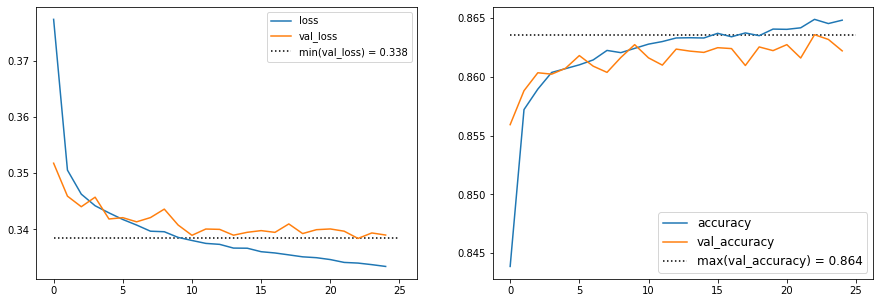

In [ ]:
histplot(history2)

Unsurprisingly, we got marginal gains by adding more features.

In [ ]:
model2 = load_model(filepath2)
y2_pred_test = model2.predict(X2_test).ravel()
auc2 = roc_auc_score(y_true=y2_test, y_score=y2_pred_test)
print("AUC",auc2)

AUC 0.892399705765976


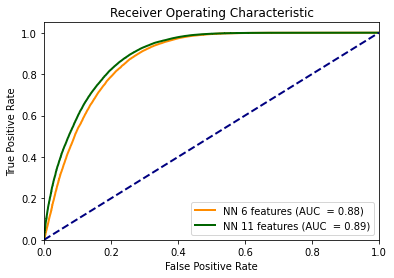

In [ ]:
# From David's code
from sklearn.metrics import roc_curve
lw = 2

fpr_1,tpr_1,_ = roc_curve(y_true=y_test, y_score=y_pred_test)
fpr_2,tpr_2,_ = roc_curve(y_true=y2_test, y_score=y2_pred_test)

plt.plot(fpr_1, tpr_1, color='darkorange',lw=lw, label='NN 6 features (AUC  = {})'.format(np.round(auc,decimals=2)))
plt.plot(fpr_2, tpr_2, color='darkgreen',lw=lw, label='NN 11 features (AUC  = {})'.format(np.round(auc2,decimals=2)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#import os
#new_dir = "Plots/Comparing" 
#if not os.path.isdir(new_dir):
#    os.mkdir(new_dir)
plt.savefig("ROC_comparing.pdf")
plt.show() # blue line = random classification -> maximize true positive rate while miniize false positive rate



 # Now moving to unsupervised learning based on clustering
## This analysis is also called segmentation

Let's do PCA 

Projecting 6-dimensional data to 2D


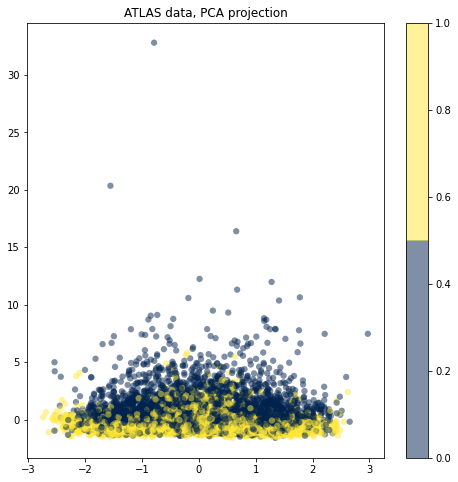

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import decomposition
from sklearn import datasets
from sklearn import ensemble 
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering


pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X_red)

print('Projecting %d-dimensional data to 2D' % X_train.shape[1])
# I've rotated PCA1 and PCA2 for visualizatino
plt.figure(figsize=(8,8))
plt.scatter(X_reduced[:, 1], X_reduced[:, 0], c=y_red, 
            edgecolor='none', alpha=0.5, s=40,
            cmap=plt.cm.get_cmap('cividis',2))
plt.colorbar()
plt.title('ATLAS data, PCA projection');
plt.show()
plt.savefig(drive_dir+'/PCA')

It looks rather messy, but we still see a separation in the PCA1 vs PCA2 space

We can ask how much info is stored as we add more PCA directions. We started with 6 variables, but the PCA analysis below tell us just 5 independent variables saturate the amounf of information

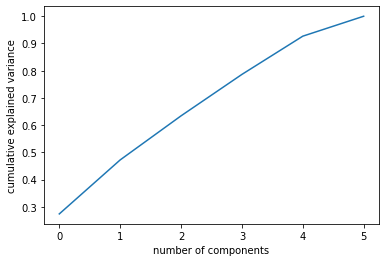

In [ ]:
pca = decomposition.PCA().fit(X_red)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


We can check how hierarchical this information is stored as we add more PCA directions. PCA1 and PCA2 already carry 47%

In [ ]:
pca = decomposition.PCA(n_components=5)
pca_transform = pca.fit_transform(X_red)
print(pca.explained_variance_ratio_)

[0.27370535 0.19838603 0.16195572 0.15224348 0.14047695]


The PCA directions map to l.c. of the original 6D variables

In [ ]:
df1.columns

Index(['met_et', 'met_phi', 'lep_pt_0', 'lep_pt_1', 'lep_phi_0', 'lep_phi_1'], dtype='object')

In [ ]:
print(np.round(pca.components_,1))

[[ 0.5  0.   0.7  0.6 -0.  -0. ]
 [ 0.   0.7 -0.  -0.  -0.6 -0.4]
 [ 0.2 -0.2 -0.  -0.2  0.4 -0.8]
 [ 0.8 -0.  -0.  -0.5 -0.2  0.3]
 [-0.1 -0.7  0.   0.1 -0.6 -0.2]]


PCA1 is a l.c. of the overall energy variables MET, PT1, PT2 and PCA2  is a l.c. of the angular Phi variables.

We are going to  keep PCA1 and PCA2 and see how far we can go in explaining the data using clustering.


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, matthews_corrcoef, roc_auc_score
modelK = KMeans(n_clusters=2)
modelKor = KMeans(n_clusters=2)
pca = decomposition.PCA(n_components=2)
X_trans= pca.fit_transform(X_red)
modelK.fit(X_trans)
modelKor.fit(X_red)

# assigned labels by K-means of 0 or 1 do not have the same meaning as our 0/1 S/B 
# so we have to 
print( "K-means clustering accuracy with original 6D data",max(balanced_accuracy_score(modelKor.labels_,y_red),balanced_accuracy_score(1-modelKor.labels_,y_red)))
print("K-means clustering accuracy with PCA transformed 2D data", max(balanced_accuracy_score(modelK.labels_,y_red),balanced_accuracy_score(1-modelK.labels_,y_red)))

K-means clustering accuracy with original 6D data 0.7033352985200689
K-means clustering accuracy with PCA transformed 2D data 0.7025417489489655


K means separates two blobs of data assigning labels to them

We see that K-means will separate S and B 70% of the time.
Not bad!

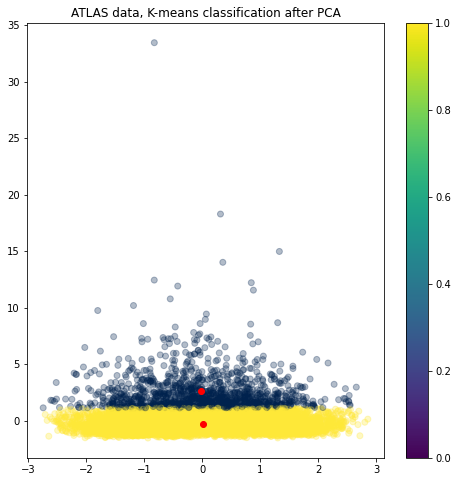

In [ ]:
plt.figure(figsize=(8,8))

plt.scatter(x=X_trans[:,1], y=X_trans[:,0], c= modelK.labels_, cmap='cividis' ,alpha=0.3)
plt.scatter(x=modelK.cluster_centers_[:, 1], y=modelK.cluster_centers_[:, 0], c=['red'])
plt.colorbar()
plt.title('ATLAS data, K-means classification after PCA');
plt.show()

If we didn't know our data contained 2 classes, would an analysis of the data tell us? A plot of inertia helps getting the 'optimal' value for clusters... that's in theory, but in practice this is very much touch  and feel

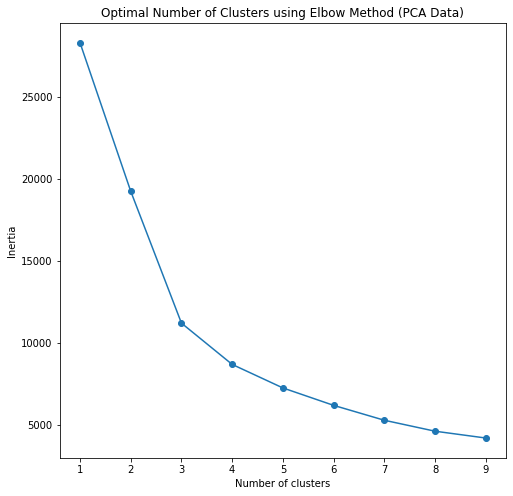

<Figure size 432x288 with 0 Axes>

In [ ]:
sse = []
k_list = range(1, 10)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(X_trans)
    sse.append([k, km.inertia_])
    
pca_results_scale = pd.DataFrame({'Cluster': range(1,10), 'SSE': sse})
plt.figure(figsize=(8,8))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (PCA Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()
plt.savefig(drive_dir+'/InertiaPCA')

## We  are going to try  2 more dimensional reduction methods, t-SNE and UMAP

To speed up clustering, I will now work with X_red, the smaller dataset

In [ ]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X_red)

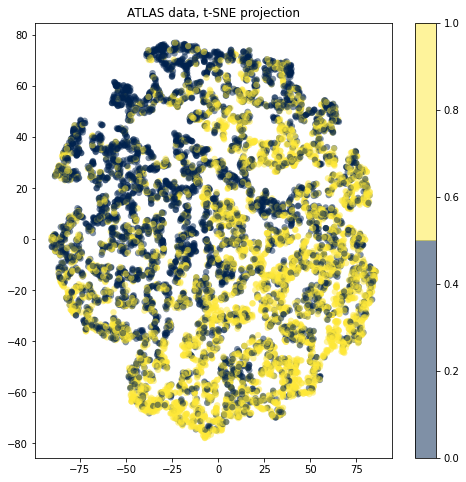

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_red, 
            edgecolor='none', alpha=0.5, s=40,
            cmap=plt.cm.get_cmap('cividis', 2))
plt.colorbar()
plt.title('ATLAS data, t-SNE projection');
plt.show()
plt.savefig(drive_dir+'/tSNE')

It doesn't look great... so going from simple, linear PCA to t-SNE we  gained nothing. That signals that a lot of the separation between S and B is encoded in simple linear relations (see the sns pairwise plots from the beginning of the notebooks), and complexifying the method and truncating to 2D does not help. Indeed, K-means on TSNE transformed data leads to worse results than on  PCA

In [ ]:

modelK = KMeans(n_clusters=2)
modelK.fit(X_tsne)

print("K-means clustering accuracy with PCA transformed 2D data")
print(max(balanced_accuracy_score(modelK.labels_,y_red),balanced_accuracy_score(1-modelK.labels_,y_red)))

K-means clustering accuracy with PCA transformed 2D data 0.6344508588115434


Let me show you another method that tends to lead to better results than TSNE when  data has non-linear relations: UMAP

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 88 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 43.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=0c124bf2ea4ffd33e1243633a153aa628a24537f18312b2a74c78ba6aa1a6582
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=6dc860a15ef2024104c044a47068252b1dbe4611feba6b617d28453846ce8377
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [ ]:
import umap.umap_ as umap
reducer = umap.UMAP()
X_reducedU = reducer.fit_transform(X_red)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


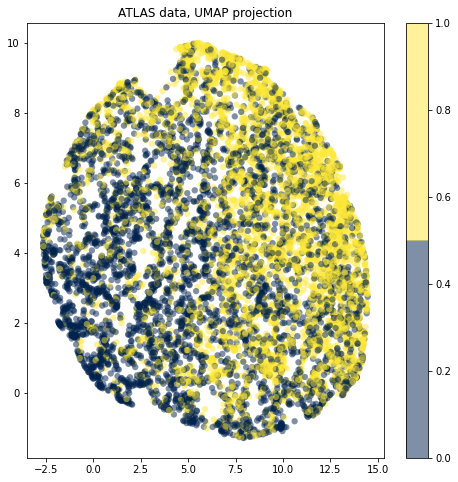

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(X_reducedU[:, 0], X_reducedU[:, 1], c=y_red, 
            edgecolor='none', alpha=0.5, s=40,
            cmap=plt.cm.get_cmap('cividis',2))
plt.colorbar()
plt.title('ATLAS data, UMAP projection');
plt.show()
plt.savefig(drive_dir+'/UMAP')


Again, nothing to write home about: the accuracy is again lower than with PCA for our HEP case. This is not the case in general,  see  my examples here for the MNIST dataset: 
 https://colab.research.google.com/drive/1Ig6HRbgDtJZybutfxOVJ3dEKKJLcpExc?usp=sharing

In [ ]:
modelK = KMeans(n_clusters=2)
modelK.fit(X_reducedU)

print("K-means clustering accuracy with PCA transformed 2D data", max(accuracy_score(modelK.labels_,y_red),accuracy_score(1-modelK.labels_,y_red)))

K-means clustering accuracy with PCA transformed 2D data 0.6469


We can also see the  possible impact of another clustering method


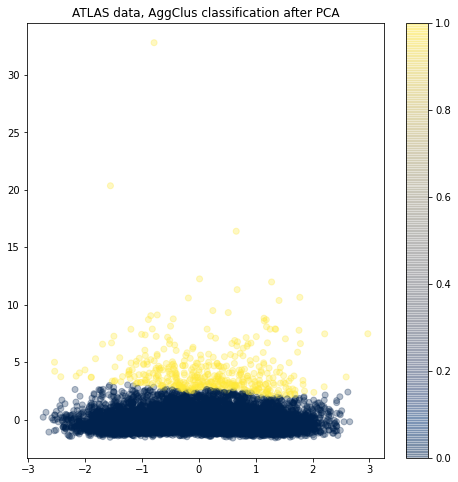

In [ ]:
modelA=AgglomerativeClustering(n_clusters=2, 
                             linkage='ward').fit(X_trans)
modelAU=AgglomerativeClustering(n_clusters=2, 
                             linkage='ward').fit(X_reducedU)
plt.figure(figsize=(8,8))

plt.scatter(x=X_trans[:,1], y=X_trans[:,0], c= modelA.labels_, cmap='cividis' ,alpha=0.3)
plt.colorbar()
plt.title('ATLAS data, AggClus classification after PCA');
plt.show()

In [ ]:
print("AggClus clustering accuracy with PCA transformed 2D data")
print(max(balanced_accuracy_score(modelA.labels_,y_red),balanced_accuracy_score(1-modelA.labels_,y_red)))
print("AggClus clustering accuracy with UMAP transformed 2D data")
print(max(balanced_accuracy_score(modelAU.labels_,y_red),balanced_accuracy_score(1-modelAU.labels_,y_red)))

AggClus clustering accuracy with PCA transformed 2D data
0.721030512250087
AggClus clustering accuracy with UMAP transformed 2D data
0.5140901275501406


Going from K-means to Aggregated leads to a 2% improvement in this case. 

This HEP data is not that 'complex' from the  clustering point of view. 

If you want to play with something fun with  more complexity, try  this one: 

https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

or look up for examples of costumer segmentation.